## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [25]:
import os
import keras
import itertools
from keras.layers import Dropout
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,Flatten

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [26]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [27]:
train, test = keras.datasets.cifar10.load_data()

In [28]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [29]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [30]:
# Dropout+BatchNormalization
def build_mlp(input_shape, regularizer,drp_ratio,output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [31]:
# Dropout + RegularizerL2
def build_mlp2(input_shape, regularizer,drp_ratio,output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=regularizer,
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=regularizer,
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [32]:
# BatchNormalization + RegularizerL2
def build_mlp3(input_shape, regularizer,drp_ratio,output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=regularizer,
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=regularizer,
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [33]:
# Dropout + BatchNormalization + RegularizerL2
def build_mlp4(input_shape, regularizer, drp_ratio,output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=regularizer,
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=regularizer,
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [34]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
DROPOUT_RATIO = 0.25
REGULIZER_RATIO = 1e-4
MODELS ={'model1:Dropout+BatchNormalization':build_mlp,
         'model2:Dropout + RegularizerL2':build_mlp2,
         'model3:BatchNormalization + RegularizerL2':build_mlp3,
         'model4:Dropout + BatchNormalization + RegularizerL2':build_mlp4}

In [35]:
# model1:Dropout+BatchNormalization
# model2:Dropout + RegularizerL2
# model3:BatchNormalization + RegularizerL2
# model4:Dropout + BatchNormalization + RegularizerL2

In [36]:
results = {}
for num, MODEL in MODELS.items():
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("%s" % num)
   
    model = MODEL(input_shape = x_train.shape[1:],
                  regularizer = regularizers.l2(REGULIZER_RATIO),
                  drp_ratio   = DROPOUT_RATIO)
    
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    model_num = "%s" % str(num)
    results[model_num] = {'train-loss': train_loss,'valid-loss': valid_loss,
                            'train-acc': train_acc,'valid-acc': valid_acc}

model1:Dropout+BatchNormalization
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)      

50000/50000 [==============================] - 2s 46us/step - loss: 1.2879 - accuracy: 0.5390 - val_loss: 1.3637 - val_accuracy: 0.5083
Epoch 44/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2829 - accuracy: 0.5388 - val_loss: 1.3654 - val_accuracy: 0.5152
Epoch 45/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2744 - accuracy: 0.5440 - val_loss: 1.3541 - val_accuracy: 0.5177
Epoch 46/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2701 - accuracy: 0.5460 - val_loss: 1.3746 - val_accuracy: 0.5118
Epoch 47/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2709 - accuracy: 0.5454 - val_loss: 1.3558 - val_accuracy: 0.5179
Epoch 48/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2675 - accuracy: 0.5448 - val_loss: 1.3131 - val_accuracy: 0.5293
Epoch 49/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2587 - accuracy: 0.5481 - val_loss: 1.3296

50000/50000 [==============================] - 2s 41us/step - loss: 1.5005 - accuracy: 0.5143 - val_loss: 1.4820 - val_accuracy: 0.5154
Epoch 39/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4877 - accuracy: 0.5174 - val_loss: 1.4758 - val_accuracy: 0.5199
Epoch 40/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4872 - accuracy: 0.5187 - val_loss: 1.4728 - val_accuracy: 0.5222
Epoch 41/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4767 - accuracy: 0.5223 - val_loss: 1.4666 - val_accuracy: 0.5236
Epoch 42/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4702 - accuracy: 0.5224 - val_loss: 1.4700 - val_accuracy: 0.5184
Epoch 43/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4646 - accuracy: 0.5280 - val_loss: 1.4654 - val_accuracy: 0.5271
Epoch 44/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4571 - accuracy: 0.5322 - val_loss: 1.4645

50000/50000 [==============================] - 2s 46us/step - loss: 0.5709 - accuracy: 0.8600 - val_loss: 2.1059 - val_accuracy: 0.4688
Epoch 34/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5433 - accuracy: 0.8694 - val_loss: 2.2493 - val_accuracy: 0.4648
Epoch 35/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5288 - accuracy: 0.8747 - val_loss: 2.1833 - val_accuracy: 0.4657
Epoch 36/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5034 - accuracy: 0.8832 - val_loss: 2.3089 - val_accuracy: 0.4538
Epoch 37/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.4879 - accuracy: 0.8898 - val_loss: 2.2679 - val_accuracy: 0.4660
Epoch 38/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.4669 - accuracy: 0.8969 - val_loss: 2.2258 - val_accuracy: 0.4692
Epoch 39/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.4644 - accuracy: 0.8984 - val_loss: 2.2157

50000/50000 [==============================] - 2s 47us/step - loss: 1.5190 - accuracy: 0.5059 - val_loss: 1.5167 - val_accuracy: 0.5038
Epoch 26/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5032 - accuracy: 0.5110 - val_loss: 1.4991 - val_accuracy: 0.5074
Epoch 27/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5001 - accuracy: 0.5083 - val_loss: 1.4885 - val_accuracy: 0.5132
Epoch 28/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4868 - accuracy: 0.5143 - val_loss: 1.4942 - val_accuracy: 0.5143
Epoch 29/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4788 - accuracy: 0.5178 - val_loss: 1.4936 - val_accuracy: 0.5146
Epoch 30/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4810 - accuracy: 0.5191 - val_loss: 1.5138 - val_accuracy: 0.5128
Epoch 31/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4771 - accuracy: 0.5197 - val_loss: 1.5227

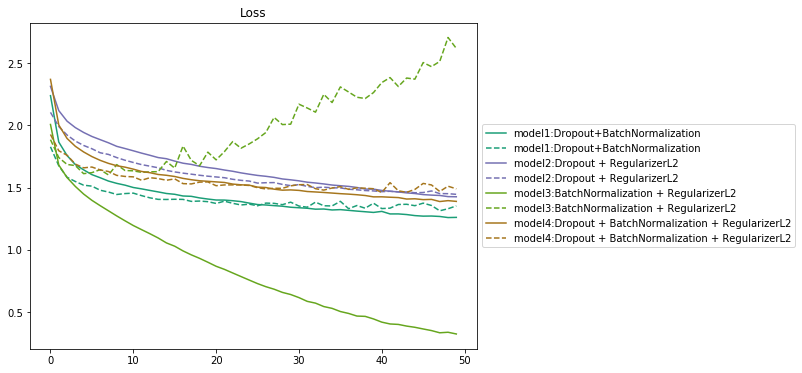

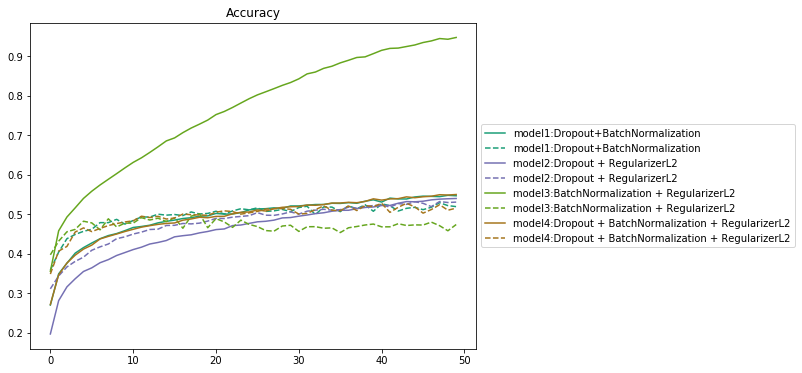

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('Dark2')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()